In [2]:
!pip list


Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.7.0
aiohttp                       3.9.0
aioitertools                  0.7.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.4
anaconda-navigator            2.5.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
archspec                      0.2.1
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.3.4
asttokens                     2.0.5
astunparse                    1.6.3
async-lru                     2.0.4
atomicwrites                  1.4.0
attrs                         23.1.0
Automat  

In [3]:
!pip install opencv-python matplotlib imageio gdown tensorflow


Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install --upgrade tensorflow


Defaulting to user installation because normal site-packages is not writeable


In [5]:
import os
import cv2
import tensorflow as tf
import numpy as np 
from typing import List
from matplotlib import pyplot as plt
import imageio


In [6]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

In [7]:
tf.config.list_physical_devices('GPU')

[]

In [8]:
#Build data loading fuctions
import gdown

In [9]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url,output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7ec1a5c4-a0f0-4d81-8cf6-9dee10ef5cd1
To: C:\Users\baafi\Documents\Projects\Lip_ml\lip_reading_app\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [04:20<00:00, 1.62MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [29]:
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32
                                    ))
    return tf.cast((frames - mean), tf.float32) / std

In [30]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [31]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [32]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(f"The vocabulary is: {char_to_num.get_vocabulary()}"
      f"(size = {char_to_num.vocabulary_size()})"
)


The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size = 40)


In [86]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding = 'UTF-8'),(-1)))[1:]

In [99]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments 

In [100]:
test_path = '.\\data\\s1\\bbaf2n.mpg'

In [101]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbaf2n'

In [104]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

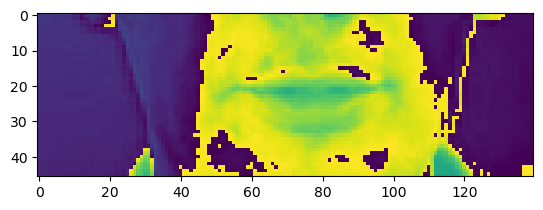

In [106]:
plt.imshow(frames[40])

In [111]:
print ([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


In [113]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_fuction(load_data,[path], (tf.float32, tf.int64))
    return result                       